# Convergence plot. Minimal BMN

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
# plt.rc("text", usetex=True)
plt.style.use("../figures/paper.mplstyle")

## Read data from disk

In [2]:
# parameters
def read_data(
    optimizer: str,
    p: dict,
):
    """Read the VQE convergence data for the mini BMN model from disk

    Args:
        optimizer (str): The optimizer used.
        p (dict): The dictionary with the parameters for the filename.
    Returns:
        pandas.DataFrame: The dataframe collecting the results of the convergence
    """
    filename = f"{p['f']}/miniBMN_l{p['l']}_convergence_{optimizer}_{p['v']}_depth{p['d']}_reps{p['n']}_max{p['m']}.h5"
    try:
        df = pd.read_hdf(filename, "vqe")
    except FileNotFoundError as e:
        print(f"{filename} not found. {e}")
        sys.exit()
    return df

In [3]:
def collect_data(
    optimizers: list,
    p: dict,
):
    """Read the VQE convergence data for the mini BMN model from disk
    Args:
        optimizer (str): The optimizer used.
        p (dict): The dictionary with the parameters for the filename.
    Returns:
        pandas.DataFrame: The dataframe collecting the all the results of the convergence
    """
    # concatenate the results from all files
    frames = [read_data(o, p) for o in optimizers]
    return pd.concat(frames, keys=optimizers, names=["Optimizer"])


Parameters

In [4]:
depth = 1
g2N = 0.2
varform = ['ry','rz']
nrep = 10
maxit = 10000
datafolder = "../data"

In [5]:
params = dict()
params["l"] = str(g2N).replace(".", "")
params["d"] = depth
params["v"] = "-".join(varform)
params["m"] = maxit
params["n"] = nrep
params["f"] = datafolder

In [6]:
df = read_data("L-BFGS-B",params)

<AxesSubplot:xlabel='counts', ylabel='energy'>

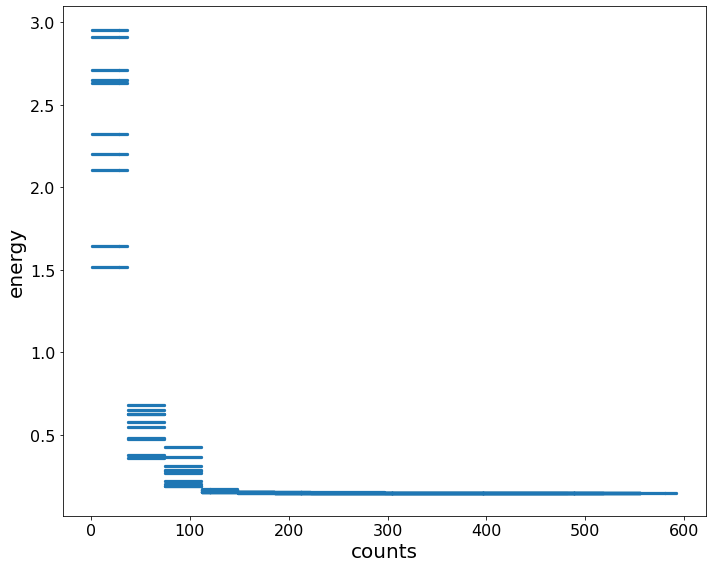

In [7]:
df.plot.scatter(x='counts',y='energy',marker='.')

Collect multiple data in one frame

In [9]:
opt_label = ["COBYLA", "L-BFGS-B","SLSQP"]#,"NELDER-MEAD"]
result = collect_data(opt_label,params)

In [10]:
# for o in opt_label:
#     result.loc[o].plot.scatter(x='counts',y='energy',marker=".",label=o)

## Get stats

In [11]:
result.groupby('Optimizer').apply(min).energy

Optimizer
COBYLA      0.15
L-BFGS-B    0.15
SLSQP       0.15
Name: energy, dtype: float64

In [12]:
gs = dict()
for r in opt_label:
    gs[r] = result.loc[r].groupby('rep').apply(min).energy
gsdf = pd.DataFrame.from_dict(gs, dtype=float)

In [13]:
gsdf

,COBYLA,L-BFGS-B,SLSQP
rep,,,
0,0.15,0.15,0.15
1,0.15,0.15,0.15
2,0.15,0.15,0.15
3,0.15,0.15,0.15
4,0.15,0.15,0.15
5,0.15,0.15,0.15
6,0.15,0.15,0.15
7,0.15,0.15,0.15
8,0.15,0.15,0.15


In [14]:
gsdf.describe().T[["min","max","mean","std"]]

,min,max,mean,std
COBYLA,0.15,0.15,0.15,7.529873e-10
L-BFGS-B,0.15,0.15,0.15,6.292386e-11
SLSQP,0.15,0.15,0.15,1.279973e-07


## Plot convergence

In [15]:
ht = 0.00328726

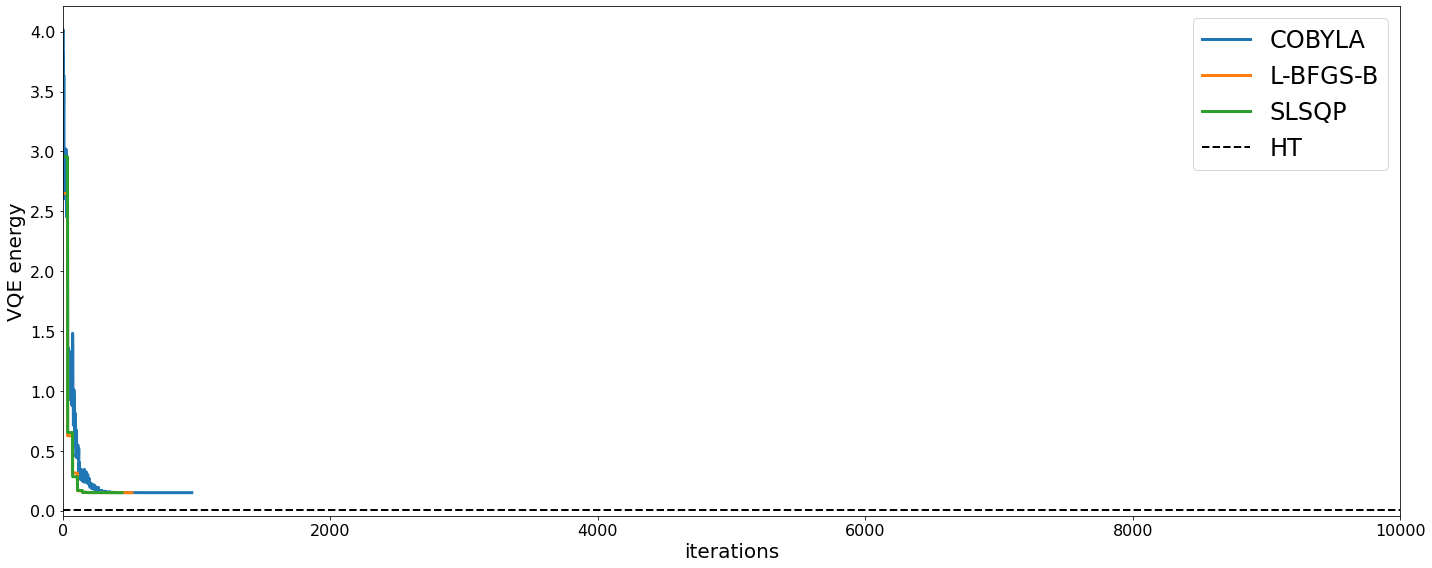

In [16]:
# select the best runs for each optimizer
fig, ax = plt.subplots(figsize=(20,8))
for o in opt_label:
    result.loc[o,gsdf[o].idxmin()].plot(x='counts',y='energy', xlim=[0,10000],label=o, ax=ax)
ax.axhline(ht,c="k",ls="--", lw="2",label="HT")
ax.set_xlabel("iterations")
ax.set_ylabel("VQE energy")
ax.legend(loc="upper right")
# filename = f"../figures/miniBMN_l{params['l']}_convergence_{params['v']}_depth{params['d']}_nr{params['n']}_max{params['m']}"
# plt.savefig(f"{filename}.pdf")
# plt.savefig(f"{filename}.png")


Zoom in

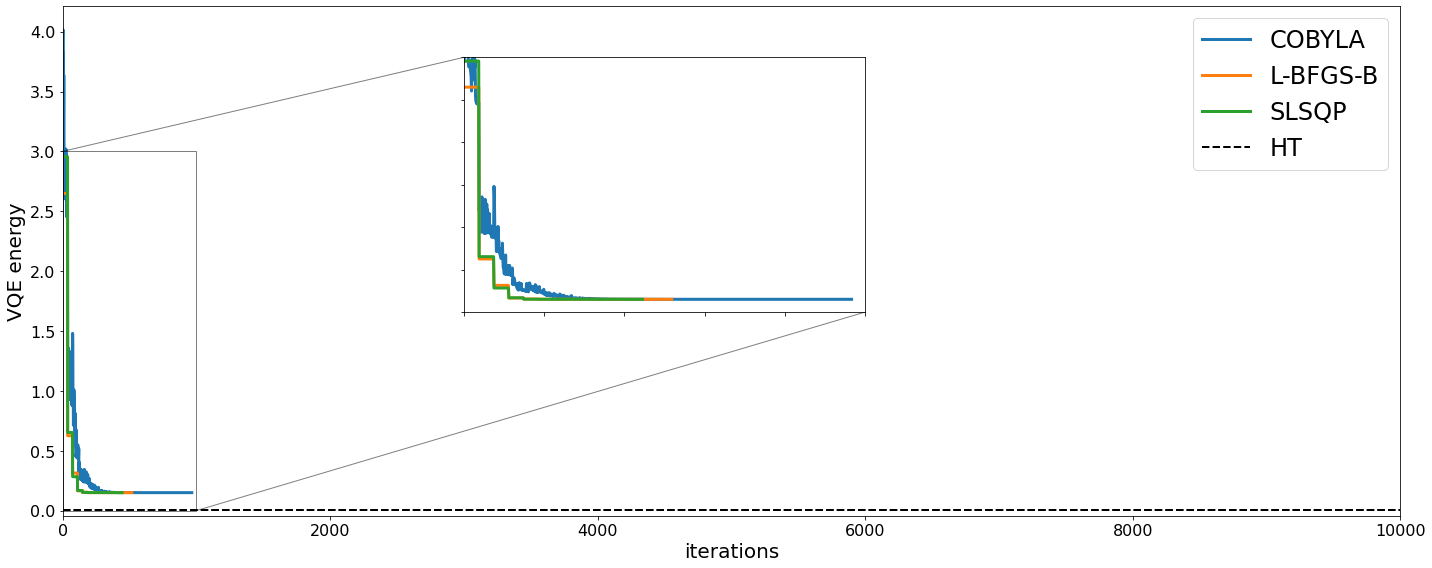

In [17]:
# select the best runs for each optimizer
fig, ax = plt.subplots(figsize=(20,8))
for o in opt_label:
    result.loc[o,gsdf[o].idxmin()].plot(x='counts',y='energy', xlim=[0,10000],label=o, ax=ax)
ax.axhline(ht,c="k",ls="--", lw="2",label="HT")

# inset axes.... bounds are [x0, y0, width, height] for where to put it
axins = ax.inset_axes([0.3, 0.4, 0.3, 0.5])

for o in opt_label:
    result.loc[o,gsdf[o].idxmin()].plot(x='counts',y='energy', xlim=[0,1000], legend=False, ax=axins)
axins.axhline(ht,c="k",ls="--", lw="2")
# sub region of the original image
x1, x2, y1, y2 = 0, 1000, 0, 3
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.set_ylabel('')
axins.set_xlabel('')

ax.indicate_inset_zoom(axins, edgecolor="black")

ax.set_xlabel("iterations")
ax.set_ylabel("VQE energy")
ax.legend(loc="upper right")
# filename = f"../figures/miniBMN_l{params['l']}_convergence_{params['v']}_depth{params['d']}_nr{params['n']}_max{params['m']}_zoom"
# plt.savefig(f"{filename}.pdf")
# plt.savefig(f"{filename}.png")

# Results from different depths

In [18]:
depths = [1,2,3,4,5,6,7]
opts = ["COBYLA","L-BFGS-B","SLSQP"]

In [19]:
for d in depths:
    params['d'] = d
    print(f"Depth={params['d']} ---------------------")
    res = collect_data(opts,params)
    gs = dict()
    for r in opts:
        gs[r] = res.loc[r].groupby('rep').apply(min).energy
    gsdf = pd.DataFrame.from_dict(gs, dtype=float)
    print(gsdf.describe().T[["min","max","mean","std"]])
    

Depth=1 ---------------------
           min   max  mean           std
COBYLA    0.15  0.15  0.15  7.529873e-10
L-BFGS-B  0.15  0.15  0.15  6.292386e-11
SLSQP     0.15  0.15  0.15  1.279973e-07
Depth=2 ---------------------
               min       max      mean           std
COBYLA    0.149748  0.150001  0.149975  7.990383e-05
L-BFGS-B  0.150000  0.150202  0.150020  6.389805e-05
SLSQP     0.150000  0.150001  0.150000  2.035404e-07
Depth=3 ---------------------
               min       max      mean           std
COBYLA    0.103518  0.150039  0.142866  1.589757e-02
L-BFGS-B  0.150000  0.150000  0.150000  1.229676e-08
SLSQP     0.150000  0.150002  0.150001  6.054314e-07
Depth=4 ---------------------
               min       max      mean       std
COBYLA    0.101246  0.150163  0.125529  0.015867
L-BFGS-B  0.153502  0.165682  0.157359  0.004197
SLSQP     0.149972  0.150019  0.149998  0.000012
Depth=5 ---------------------
               min       max      mean       std
COBYLA    0.09215

In [20]:
ds = dict()
for d in depths:
    params['d'] = d
    res = collect_data(opts,params)
    ds[d] = res.groupby('Optimizer').apply(min).energy

In [21]:
dfds = pd.DataFrame.from_dict(ds,orient='index',dtype=float).rename_axis("depth")
dfds

,COBYLA,L-BFGS-B,SLSQP
depth,,,
1,0.150000,0.150000,0.150000
2,0.149748,0.150000,0.150000
3,0.103518,0.150000,0.150000
4,0.101246,0.153502,0.149972
5,0.092156,0.157810,0.076746
6,0.079161,0.220411,0.072089
7,0.078458,0.501309,0.072952


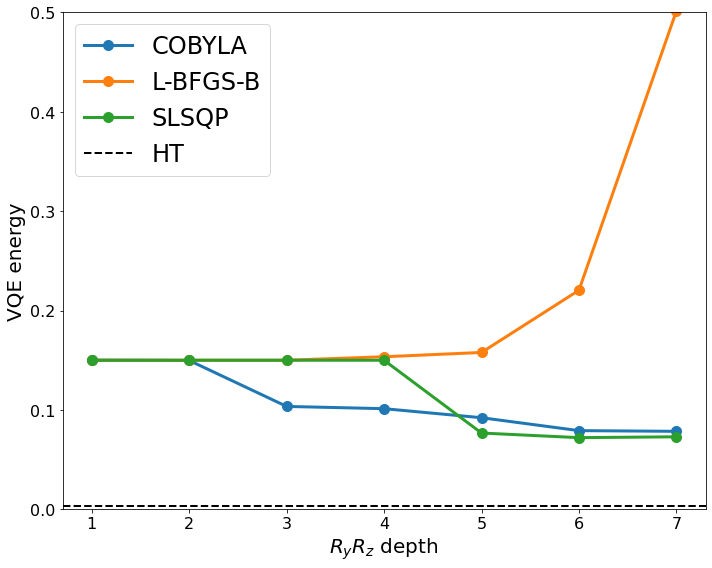

In [22]:
ht = 0.00328726
fig, ax = plt.subplots()
dfds.plot(marker="o", ylim=[0,0.5], ax=ax)
ax.axhline(ht,c="k",ls="--",lw="2",label="HT")
ax.set_ylabel("VQE energy")
ax.set_xlabel(r"$R_yR_z$"+" depth")
ax.legend(loc="upper left")
# plt.savefig("../figures/miniBMN_l02_ry-rz_nr10_max10000_depths.pdf")
# plt.savefig("../figures/miniBMN_l02_ry-rz_nr10_max10000_depths.png")

# Convergence plot. Bosonic BMN

## Get data

In [48]:
# parameters
def read_data_bos(
    optimizer: str,
    p: dict,
):
    """Read the VQE convergence data for the mini BMN model from disk

    Args:
        optimizer (str): The optimizer used.
        p (dict): The dictionary with the parameters for the filename.
    Returns:
        pandas.DataFrame: The dataframe collecting the results of the convergence
    """
    filename = f"{p['f']}_l{p['l']}_convergence_{optimizer}_{p['v']}_depth{p['d']}_reps{p['n']}_max{p['m']}.h5"
    try:
        df = pd.read_hdf(filename, "vqe")
    except FileNotFoundError as e:
        print(f"{filename} not found. {e}")
        sys.exit()
    return df


def collect_data_bos(
    optimizers: list,
    p: dict,
):
    """Read the VQE convergence data for the mini BMN model from disk
    Args:
        optimizer (str): The optimizer used.
        p (dict): The dictionary with the parameters for the filename.
    Returns:
        pandas.DataFrame: The dataframe collecting the all the results of the convergence
    """
    # concatenate the results from all files
    frames = [read_data_bos(o, p) for o in optimizers]
    return pd.concat(frames, keys=optimizers, names=["Optimizer"])


In [95]:
depth = 3
g2N = 0.2
varform = ['ry','rz']
nrep = 10
maxit = 10000
dataprefix = "../data/bosBMN_L2"

In [96]:
params = dict()
params["l"] = str(g2N).replace(".", "")
params["d"] = depth
params["v"] = "-".join(varform)
params["m"] = maxit
params["n"] = nrep
params["f"] = dataprefix

In [97]:
opt_label = ["COBYLA","L-BFGS-B","SLSQP","NELDER-MEAD"]
result = collect_data_bos(opt_label,params)

Minimum energy

In [98]:
result.groupby('Optimizer').apply(min)

,counts,energy
Optimizer,,
COBYLA,1.0,3.149378
L-BFGS-B,1.0,3.150000
SLSQP,1.0,3.150000
NELDER-MEAD,1.0,3.149918


Get stats

In [99]:
gs = dict()
for r in opt_label:
    gs[r] = result.loc[r].groupby('rep').apply(min).energy
gsdf = pd.DataFrame.from_dict(gs, dtype=float)

In [100]:
gsdf.describe().T[["min","max","mean","std"]]

,min,max,mean,std
COBYLA,3.149378,3.150003,3.149809,2.429102e-04
L-BFGS-B,3.150000,3.150000,3.150000,7.799010e-09
SLSQP,3.150000,3.150046,3.150005,1.429296e-05
NELDER-MEAD,3.149918,3.157584,3.151612,2.254151e-03


## Plot convergence

In [101]:
ht = 3.14807787

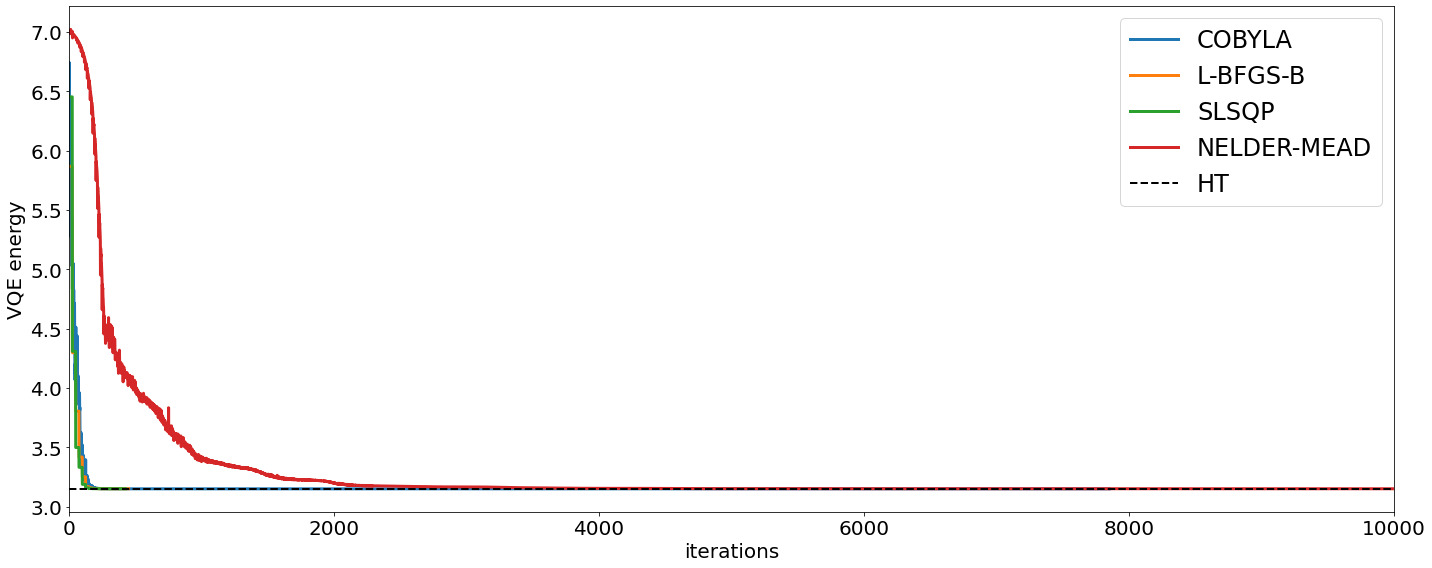

In [102]:
# select the best runs for each optimizer
fig, ax = plt.subplots(figsize=(20,8))
for o in opt_label:
    result.loc[o,gsdf[o].idxmin()].plot(x='counts',y='energy', xlim=[0,10000],label=o, ax=ax)
ax.axhline(ht,c="k",ls="--", lw="2",label="HT")
ax.set_xlabel("iterations")
ax.set_ylabel("VQE energy")
ax.legend(loc="upper right")
# filename = f"../figures/miniBMN_l{params['l']}_convergence_{params['v']}_depth{params['d']}_nr{params['n']}_max{params['m']}"
# plt.savefig(f"{filename}.pdf")
# plt.savefig(f"{filename}.png")

Zoom in

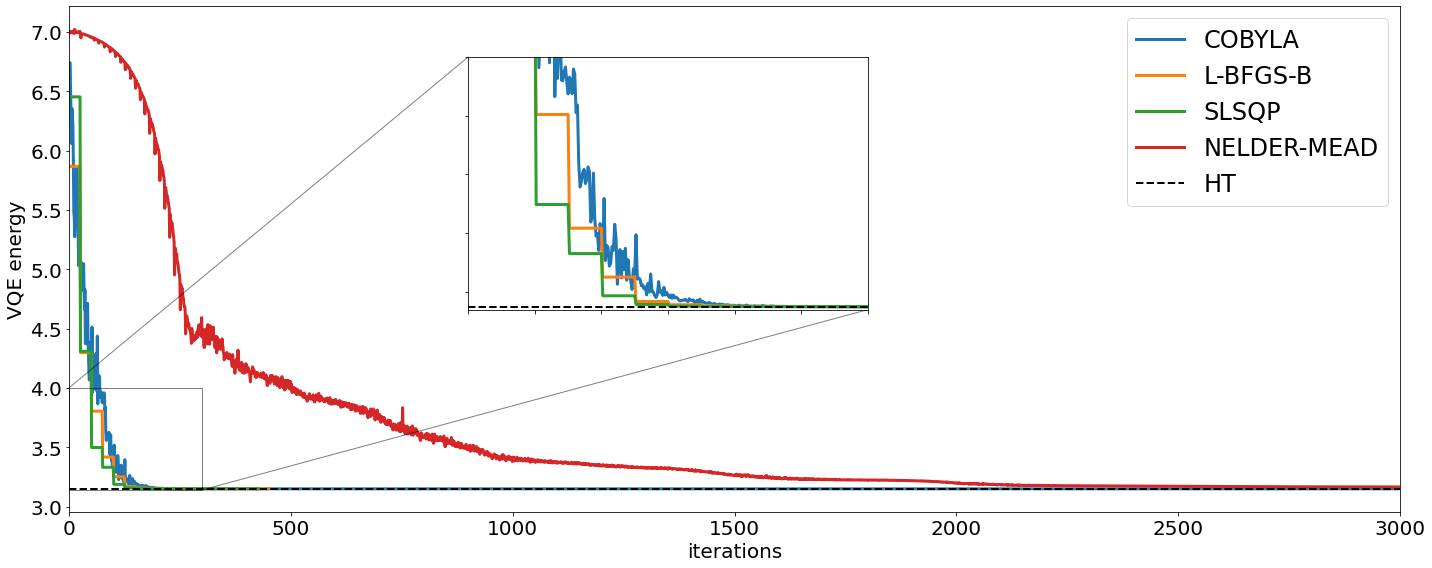

In [105]:
# select the best runs for each optimizer
fig, ax = plt.subplots(figsize=(20,8))
for o in opt_label:
    result.loc[o,gsdf[o].idxmin()].plot(x='counts',y='energy', xlim=[0,6000],label=o, ax=ax)
ax.axhline(ht,c="k",ls="--", lw="2",label="HT")

# inset axes.... bounds are [x0, y0, width, height] for where to put it
axins = ax.inset_axes([0.3, 0.4, 0.3, 0.5])

for o in opt_label:
    result.loc[o,gsdf[o].idxmin()].plot(x='counts',y='energy', xlim=[0,600], legend=False, ax=axins)
axins.axhline(ht,c="k",ls="--", lw="2")
# sub region of the original image
x1, x2, y1, y2 = 0, 600, 3.14, 4
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.set_ylabel('')
axins.set_xlabel('')

ax.indicate_inset_zoom(axins, edgecolor="black")

ax.set_xlabel("iterations")
ax.set_ylabel("VQE energy")
ax.legend(loc="upper right")
figprefix = dataprefix.replace("data","figures")
filename = f"{figprefix}_l{params['l']}_convergence_{params['v']}_depth{params['d']}_nr{params['n']}_max{params['m']}_zoom"
plt.savefig(f"{filename}.pdf")
plt.savefig(f"{filename}.png")
plt.savefig(f"{filename}.svg")